In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [27]:
df = pd.read_csv("data/smhi-lufttemperatur.csv", sep=";")

In [28]:
df

,Datum,Tid (UTC),Lufttemperatur,Kvalitet
0,2010-03-01,00:00:00,2.0,G
1,2010-03-01,01:00:00,2.2,Y
2,2010-03-01,02:00:00,2.2,Y
3,2010-03-01,03:00:00,1.7,G
4,2010-03-01,04:00:00,1.7,Y
...,...,...,...,...
108214,2022-08-01,02:00:00,16.2,G
108215,2022-08-01,03:00:00,16.0,G
108216,2022-08-01,04:00:00,16.1,G
108217,2022-08-01,05:00:00,17.4,G


### Data preprocessing

In [29]:
def transform(df_: pd.DataFrame) -> pd.DataFrame:
    return (df_
        .rename(columns={"Lufttemperatur": "y", "Kvalitet": "quality"})
        .assign(ds=pd.to_datetime(df_["Datum"] + " " + df_["Tid (UTC)"]))
        .query("quality != 'Y'")
        .loc[:, ("ds", "y")] # type: ignore
        .astype({"y": np.int8}))

In [30]:
weather = transform(df)

In [31]:
weather

,ds,y
0,2010-03-01 00:00:00,2
3,2010-03-01 03:00:00,1
6,2010-03-01 06:00:00,1
9,2010-03-01 09:00:00,1
12,2010-03-01 12:00:00,1
...,...,...
108214,2022-08-01 02:00:00,16
108215,2022-08-01 03:00:00,16
108216,2022-08-01 04:00:00,16
108217,2022-08-01 05:00:00,17


In [32]:
weather.min(), weather.max()

(ds    2010-03-01 00:00:00
 y                     -14
 dtype: object, ds    2022-08-01 06:00:00
 y                      30
 dtype: object)

In [33]:
weather.isna().sum()

ds    0
y     0
dtype: int64

### Data exploration

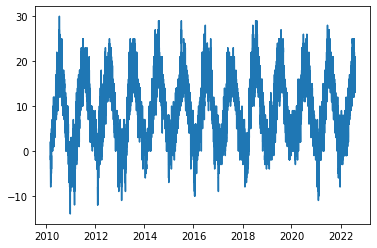

In [39]:
#weather.plot()
plt.plot(weather.ds, weather.y);

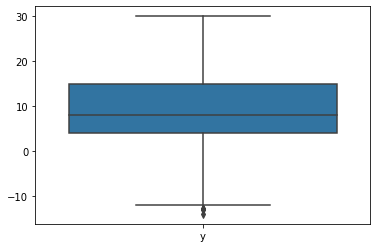

In [40]:
sns.boxplot(data=weather);

### 1. Spliting

In [102]:
# split data into predictors and response
train = weather[weather['ds'] < pd.Timestamp('2020-02-25')] 
test = weather[weather['ds'] >= pd.Timestamp('2020-02-25')]

In [125]:
test.ds.max() - test.ds.min()

Timedelta('888 days 06:00:00')

In [49]:
# fit model - ignore train/test split for now
m = Prophet()
m.fit(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n9f74t6/5_9piml8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_n9f74t6/3mwqrmvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25937', 'data', 'file=/tmp/tmp_n9f74t6/5_9piml8.json', 'init=/tmp/tmp_n9f74t6/3mwqrmvy.json', 'output', 'file=/tmp/tmp_n9f74t6/prophet_model5u6hwkmf/prophet_model-20221227184603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:46:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [142]:
future = m.make_future_dataframe(freq="D", periods=888) #include_history=False

In [143]:
future

,ds
0,2010-03-01 00:00:00
1,2010-03-01 03:00:00
2,2010-03-01 06:00:00
3,2010-03-01 09:00:00
4,2010-03-01 12:00:00
...,...
85569,2022-07-27 23:00:00
85570,2022-07-28 23:00:00
85571,2022-07-29 23:00:00
85572,2022-07-30 23:00:00


In [144]:
forecast = m.predict(future)

In [148]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
85569,2022-07-27 23:00:00,21.506888,0.662109,43.279597
85570,2022-07-28 23:00:00,21.577537,0.088116,43.660515
85571,2022-07-29 23:00:00,21.519601,-1.154158,43.188442
85572,2022-07-30 23:00:00,21.555668,0.944997,43.304678
85573,2022-07-31 23:00:00,21.551631,-0.390979,42.859024


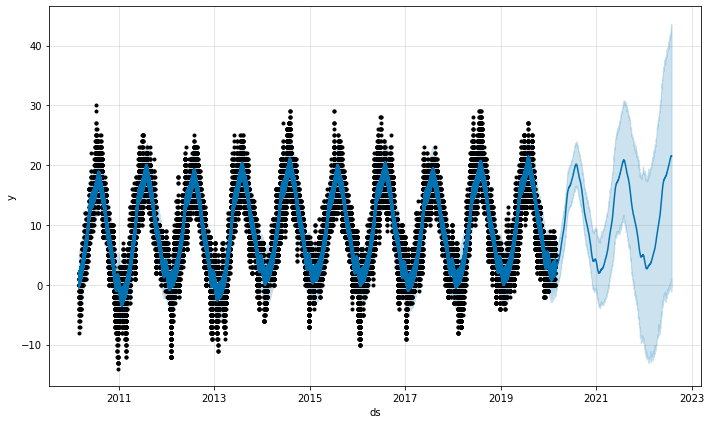

In [146]:
fig1 = m.plot(forecast)

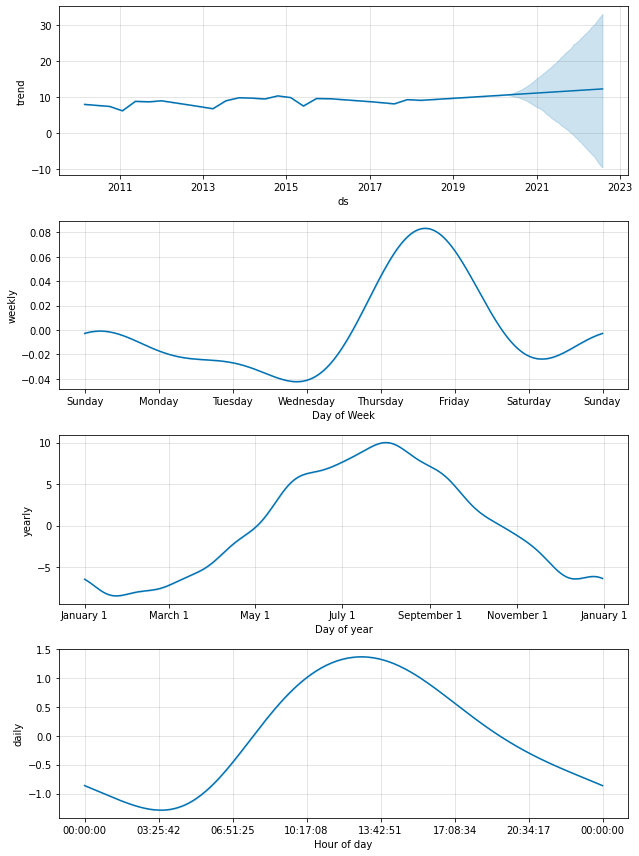

In [149]:
fig2 = m.plot_components(forecast)

In [197]:
pred = pd.DataFrame(dict(date=test.loc[test.ds.dt.hour.isin([23])].ds, y=test.loc[test.ds.dt.hour.isin([23])].y.values, yhat=forecast.tail(883).yhat.values))

In [204]:
pred

,date,y,yhat
87045,2020-02-25 23:00:00,4,2.657301
87069,2020-02-26 23:00:00,0,2.726519
87093,2020-02-27 23:00:00,-1,2.792564
87117,2020-02-28 23:00:00,2,2.956208
87141,2020-02-29 23:00:00,5,3.069618
...,...,...,...
108115,2022-07-27 23:00:00,15,21.506888
108139,2022-07-28 23:00:00,14,21.577537
108163,2022-07-29 23:00:00,15,21.519601
108187,2022-07-30 23:00:00,15,21.555668


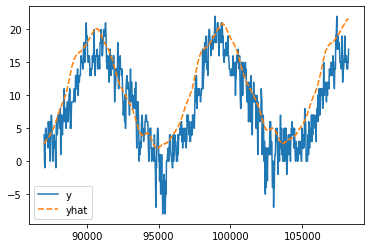

In [212]:
sns.lineplot(data=pred);

In [214]:
mean_squared_error(pred.y, pred.yhat)

13.666949616745233

### 2. Modeling

### 3. Evaluatiation